In [145]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
import math
sns.set()

In [146]:
stock_name='HD'

In [147]:
df = pd.read_csv('../../dataset/5year/'+stock_name+'-5year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-05-27,79.379997,80.000000,79.300003,79.690002,71.448708,4760600
1,2014-05-28,79.750000,80.000000,79.269997,79.680000,71.439735,4002200
2,2014-05-29,79.879997,79.989998,79.440002,79.900002,71.636978,4408900
3,2014-05-30,79.769997,80.269997,79.580002,80.230003,71.932869,4528000
4,2014-06-02,80.250000,81.059998,80.169998,80.839996,72.479774,6817700


In [148]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.010436,0.010304,0.011589,0.011931,0.007419,0.168615
1,0.013155,0.010304,0.011364,0.011857,0.007355,0.129189
2,0.014110,0.010231,0.012636,0.013478,0.008758,0.150332
3,0.013302,0.012277,0.013682,0.015908,0.010863,0.156523
4,0.016830,0.018050,0.018093,0.020401,0.014752,0.275555


In [149]:
train_percentage=0.67
df_train=df_log[:math.ceil(train_percentage*df_log.shape[0])]
df_test=df_log[math.ceil(train_percentage*df_log.shape[0]):]

In [150]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        self.residue=self.Y - self.logits

In [151]:
num_layers = 1
size_layer = 6
timestamp = 5
epoch = 50
dropout_rate = 0.3
future_day = 60

In [152]:
tf.reset_default_graph()
modelnn = Model(
    0.01, num_layers, df_train.shape[1], size_layer, df_train.shape[1], dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

E:\Anacoda3 REAL\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [153]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_train.shape[0] - 1, timestamp):
        #print(k)
        index = min(k + timestamp, df_train.shape[0] -1)
        batch_x = np.expand_dims(
            df_train.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_train.iloc[k + 1 : index + 1, :].values
        last_state, _, loss,residue = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost,modelnn.residue],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        if i==epoch-1:
            if k==0:
                last_residue=residue
            else:
                last_residue=np.vstack((last_residue,residue))
        init_value = last_state
        total_loss += loss
    total_loss /= df_train.shape[0] // timestamp
    if (i + 1) % 50 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)
    
        

epoch: 50 avg loss: 0.009849487352593791


In [154]:
last_residue.shape

(843, 6)

In [155]:
inv_residue=minmax.inverse_transform(last_residue)
#print(inv_residue)
print(np.std(inv_residue[:,4]))
resid_std=np.std(inv_residue[:,4])

13.212528


In [156]:
output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
output_predict[0] = df_train.iloc[0]
upper_b = (df_train.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_train.iloc[k : k + timestamp], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
        modelnn.hidden_layer: init_value,
    },
)
init_value = last_state
output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
df_train.loc[df_train.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

E:\Anacoda3 REAL\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [157]:
test_step60=df_train.copy()
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(test_step60.iloc[-timestamp:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[test_step60.shape[0]] = out_logits[-1]
    test_step60.loc[test_step60.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [158]:
output_predict.shape

(904, 6)

In [159]:
inv_yhat=minmax.inverse_transform(output_predict)
inv_test=minmax.inverse_transform(df_test)
upper_list,lower_list,rvalue_list,pvalue_list=[],[],[],[]
for i in range(10):
    pvalue=inv_yhat[df_train.shape[0]+i,4]
    upper_bound=pvalue+1.15*resid_std*math.sqrt(i+1)
    lower_bound=pvalue-1.15*resid_std*math.sqrt(i+1)
    rvalue=inv_test[i,4]
    print(i,upper_bound,lower_bound,rvalue)
    upper_list.append(upper_bound)
    lower_list.append(lower_bound)
    rvalue_list.append(rvalue)
    pvalue_list.append(pvalue)

0 165.50570945533582 135.11689452918836 157.96307373046878
1 172.04642105022842 129.0701468372247 158.40733337402344
2 177.24763794245382 124.61266650855896 159.5179901123047
3 183.76180143051715 122.98417157822223 159.63388061523438
4 184.52442460782993 116.57296867730395 160.43547058105466
5 188.90216378732904 114.46507333039452 160.17471313476562
6 190.97072474987198 110.56947781731816 160.03952026367188
7 189.17761584914425 103.22506742313689 159.50831604003903
8 196.7277228680141 105.56127808957172 159.59524536132812
9 197.10796310232365 101.01009254237613 158.95782470703125


In [160]:
print(pvalue_list)
print(rvalue_list)

[150.3113019922621, 150.55828394372656, 150.9301522255064, 153.3729865043697, 150.54869664256694, 151.68361855886178, 150.77010128359507, 146.20134163614057, 151.1445004787929, 149.0590278223499]
[157.96307373046878, 158.40733337402344, 159.5179901123047, 159.63388061523438, 160.43547058105466, 160.17471313476562, 160.03952026367188, 159.50831604003903, 159.59524536132812, 158.95782470703125]


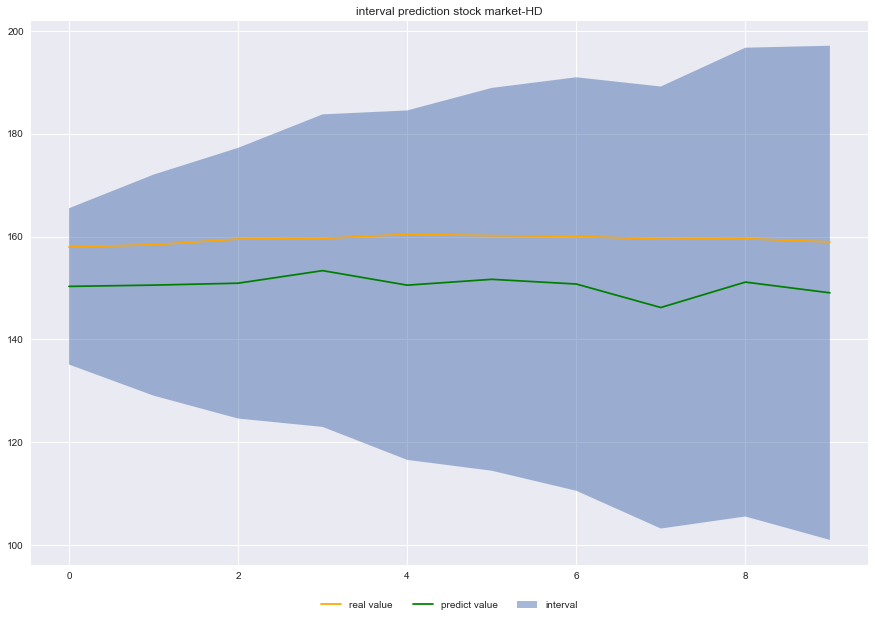

In [161]:
plt.figure(figsize = (15, 10))
plt.fill_between([k for k in range(len(upper_list))],upper_list,lower_list,label='interval',alpha=0.5)
plt.plot(rvalue_list,label='real value',color='orange')
plt.plot(pvalue_list,label='predict value',color='green')
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('interval prediction stock market-%s'%stock_name)
plt.savefig('../../image/Interval/'+stock_name+'+10.png')
plt.show()

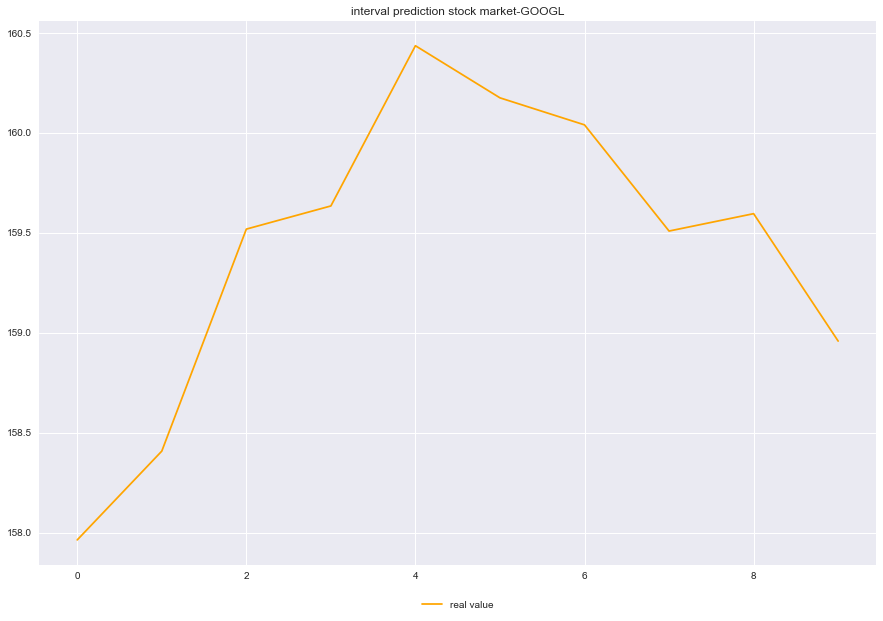

In [162]:
plt.figure(figsize = (15, 10))
plt.plot(inv_test[:10,4],label='real value',color='orange')
# plt.plot(inv_yhat[-future_day:,4],label='predict value',color='green')
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('interval prediction stock market-GOOGL')
plt.show()